In [81]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_profiling
import datetime
import json
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import  accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
import category_encoders as ce
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.utils.multiclass import unique_labels
from sklearn.ensemble import RandomForestClassifier
from pdpbox.pdp import pdp_interact, pdp_interact_plot, pdp_isolate, pdp_plot
import matplotlib.pyplot as plt

In [26]:
df = pd.read_csv('/Users/karthikmahendra/Downloads/traindata.csv')

In [27]:
train = df[df['launched_at_year'] != 2019]
test = df[df['launched_at_year'] == 2019]

In [28]:
target = 'state'
X_train = train.drop(columns=target)
X_test = test.drop(columns=target)
y_test = test[target]
y_train = train[target]

In [29]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((169383, 28), (22943, 28), (169383,), (22943,))

In [30]:
y_pred_base = np.full_like(y_test,fill_value = 'successful')

In [31]:
print('baseline accuracy:', accuracy_score(y_test, y_pred_base))

baseline accuracy: 0.8069999564137209


In [32]:
numerical_features = ['fx_rate','goal',
                     'static_usd_rate','launched_at_year','campaign_duration_days',
                     'launched_at_month','launched_at_day','launched_at_hour','deadline_year',
                     'deadline_month','created_at_year','created_at_month','created_at_day',
                     'created_at_hour','campaign_launch_delay_days','campaign_launch_delay_secs']
cat_features = ['original_country','currency','current_currency',
               'usd_type','category','sub-category']
bool_features = ['currency_trailing_code','staff_pick']
other = ['location','creator']

In [33]:
# numeric_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler())])
# ordinal_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('ord', ce.OrdinalEncoder())]) 
# #boolean_transformer = Pipeline(steps=[
#  #   ('imputer', SimpleImputer(strategy='most_frequent'))])
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numerical_features),
#         ('ond', ordinal_transformer, cat_features)])

In [34]:
# classification = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('xg',XGBClassifier(n_estimators=1000,max_depth=4,random_state=42, n_jobs=-1))])

In [ ]:
# model = XGBClassifier(n_jobs=-1, random_state=42)
# param_dist = {'max_depth': randint(3,12),
#               'learning_rate': uniform(0,1),
#               'n_estimators': randint(200, 1500),
#               'min_child_weight': randint(1,10),
#               'gamma': randint(0,5),
#               'subsample': [0.6, 0.7, 0.8, 0.9, 1],
#               'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1],
#               }

# search = RandomizedSearchCV(model,
#                             param_distributions=param_dist,
#                             cv=5,
#                             scoring='accuracy',
#                             verbose=10,
#                             return_train_score=True)

# search.fit(X_train, y_train)
# print('Best hyperparameters', search.best_params_)
# print('Best score', search.best_score_)

In [48]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.fit_transform(X_test)

In [49]:
model = XGBClassifier(n_estimators=1191,min_child_weight=6,max_depth=10,colsample_bytree=0.7,
                          gamma=3,learning_rate=0.9824937724774578,subsample=1,
                          random_state=42, n_jobs=-1)

In [42]:
#model = XGBClassifier(n_estimators=1000,max_depth=5,random_state=42, n_jobs=-1)

In [39]:
# #model = RandomForestClassifier(n_estimators=200, min_samples_split=3,
#                             criterion='gini', max_features='auto', oob_score=True,
#                               random_state=5, n_jobs=-1,class_weight = 'balanced')

In [50]:
model.fit(X_train_encoded, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, gamma=3,
       learning_rate=0.9824937724774578, max_delta_step=0, max_depth=10,
       min_child_weight=6, missing=None, n_estimators=1191, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [51]:
y_pred = model.predict(X_test_encoded)
print('test accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

test accuracy: 0.8284444057010854
              precision    recall  f1-score   support

      failed       0.54      0.69      0.61      4428
  successful       0.92      0.86      0.89     18515

   micro avg       0.83      0.83      0.83     22943
   macro avg       0.73      0.78      0.75     22943
weighted avg       0.85      0.83      0.84     22943



In [52]:
def plot_confusion_matrix(y_true,y_pred,normalize=False):
    columns = [f'Predicted "{c}"'for c in unique_labels(y_pred)]
    index_names = [f'Actual "{c}"'for c in unique_labels(y_true)]
    cm = confusion_matrix(y_true,y_pred)
    if normalize:
        cm=cm/cm.sum(axis=1).reshape(y_true.nunique(),1)
    df = pd.DataFrame(cm,columns = columns,index = index_names)
    sns.heatmap(df,cmap='viridis',annot=True,fmt='.2f');

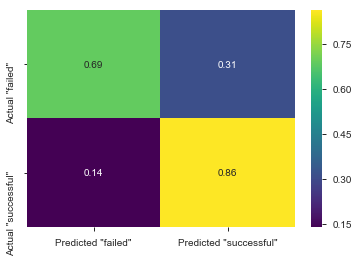

In [53]:
plot_confusion_matrix(y_test,y_pred,normalize=True)

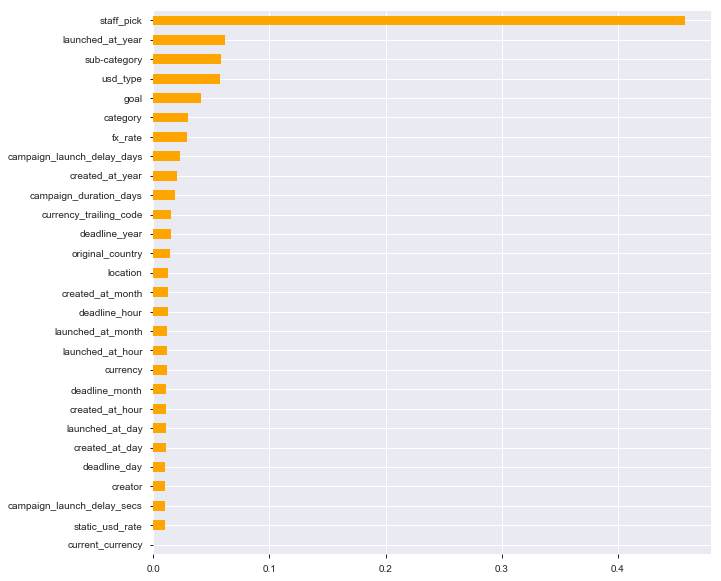

In [96]:
# Feature Importance
plt.figure(figsize=(10,10))
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=True)
feat_importances.plot(kind='barh',color='orange')

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a3787e0b8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2ccce2b0>})

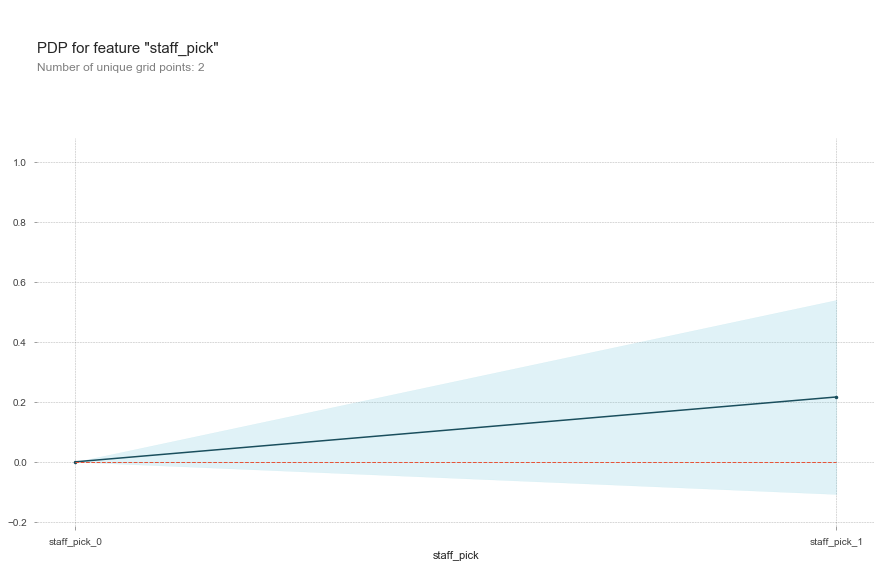

In [63]:
features ='staff_pick'

isolated = pdp_isolate(
    model=model, 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=features
)

pdp_plot(isolated, feature_name=features)

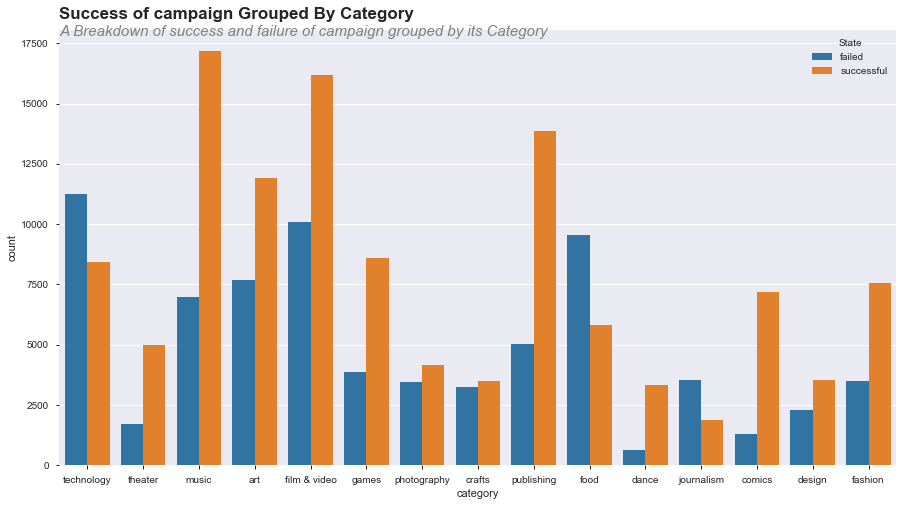

In [64]:
# Using the five thirty eight style
plt.style.context('fivethirtyeight')
plt.figure(figsize=(15,8))

# Setting plot and details
ax = sns.countplot(x = "category", hue="state", data=df)
ax.text(s="Success of campaign Grouped By Category", y=18500, x=-0.5, fontsize=17, fontweight='semibold');
ax.text(s="A Breakdown of success and failure of campaign grouped by its Category", y=17800, x=-0.5, fontsize=15, fontstyle='italic', color='grey')
l = ax.legend()
l.set_title('State')
sns.despine(ax=ax, left=True)